In [1]:
############## Part to Whole Analysis
# Importing Necessary libraries
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

server = 'LAPTOP-LFBT0G3K'
database = 'DataWarehouse'
driver = '{ODBC Driver 18 for SQL Server}'

cnxn = None

In [4]:
# Connection and query loading
try:
    connection_string = (
        f'DRIVER={driver};'
        f'SERVER={server};'
        f'DATABASE={database};'
        'Trusted_Connection=yes;'
        'Encrypt=yes;'
        'TrustServerCertificate=yes;'
    )
    
    print(f"Attempting to connect to {server}/{database} using driver: {driver}")
    cnxn = pyodbc.connect(connection_string)
    print("Successfully connected to SQL Server!")
    
    sql_analysis_query="""
                            SELECT
                                order_date,
                                total_sales,
                                SUM(total_sales) OVER (ORDER BY order_date) AS running_total_sales,
                                AVG(avg_price) OVER (ORDER BY order_date) AS moving_average_price
                        FROM
                        (
                            SELECT
                                DATETRUNC(year, order_date) AS order_date,
                                SUM(sales_amount) AS total_sales,
                                AVG(price) AS avg_price
                            FROM gold.fact_sales
                            WHERE order_date IS NOT NULL
                            GROUP BY DATETRUNC(year, order_date)
                        ) t
    """
    df_cumm_analysis=pd.read_sql(sql_analysis_query,cnxn)

except pyodbc.Error as ex:
    sqlstate = ex.args[0]
    print(f"Connection or query error: {ex}")
    if 'IM002' in sqlstate:
        print(f"  --> Driver '{driver}' not found or improperly configured.")
    elif '08001' in sqlstate:
        print(f"  --> Connection failed. Verify server name, database, and network connectivity.")
    elif '28000' in sqlstate:
        print(f"  --> Authentication error. Ensure your Windows user has appropriate SQL Server permissions.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    if cnxn:
        cnxn.close()
        print("\nConnection closed.")

Attempting to connect to LAPTOP-LFBT0G3K/DataWarehouse using driver: {ODBC Driver 18 for SQL Server}
Successfully connected to SQL Server!


C:\Users\Ayush\AppData\Local\Temp\ipykernel_26124\2270821419.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cumm_analysis=pd.read_sql(sql_analysis_query,cnxn)


In [6]:
# Testing our data
print('first 5 rows fo sales analysis Data : ')
print(df_cumm_analysis.head())
print('\nSales Analysis Data info : ')
print(df_cumm_analysis.info())

first 5 rows fo sales analysis Data : 
   order_date  total_sales  running_total_sales  moving_average_price
0  2010-01-01        43419                43419                  3101
1  2011-01-01      7075088              7118507                  3146
2  2012-01-01      5842231             12960738                  2670
3  2013-01-01     16344878             29305616                  2080
4  2014-01-01        45642             29351258                  1668

Sales Analysis Data info : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   order_date            5 non-null      object
 1   total_sales           5 non-null      int64 
 2   running_total_sales   5 non-null      int64 
 3   moving_average_price  5 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 288.0+ bytes
None


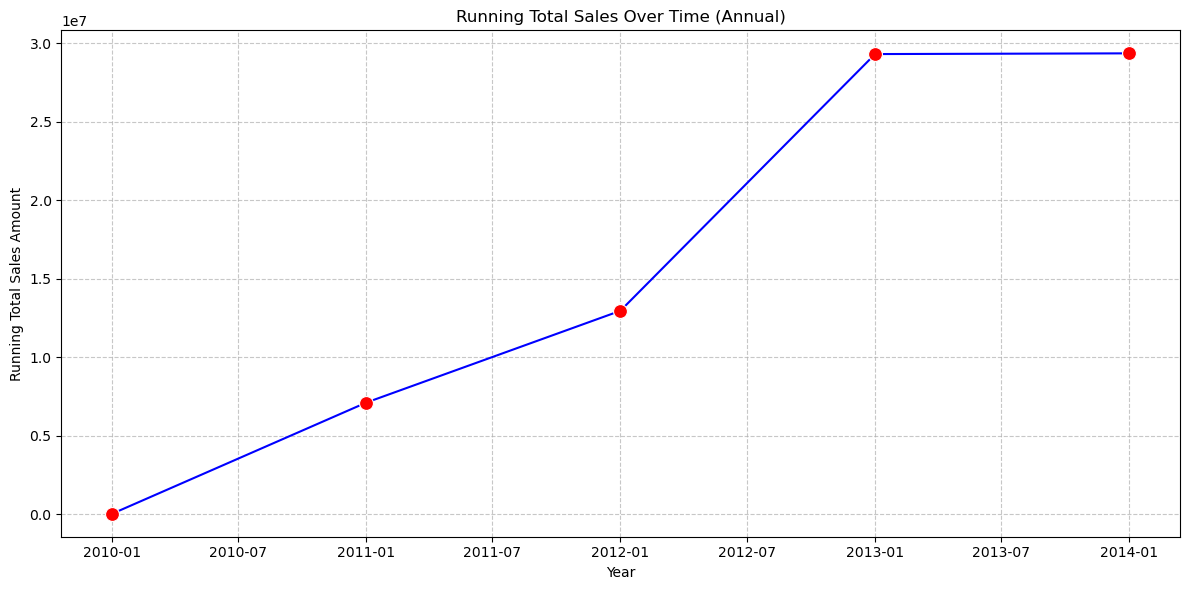

In [7]:
# 1. Running Total Sales Over Time (Annual)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_cumm_analysis, x='order_date', y='running_total_sales', marker='o', color='blue')
sns.scatterplot(data=df_cumm_analysis, x='order_date', y='running_total_sales', color='red', s=100, zorder=5)
plt.title('Running Total Sales Over Time (Annual)')
plt.xlabel('Year')
plt.ylabel('Running Total Sales Amount')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

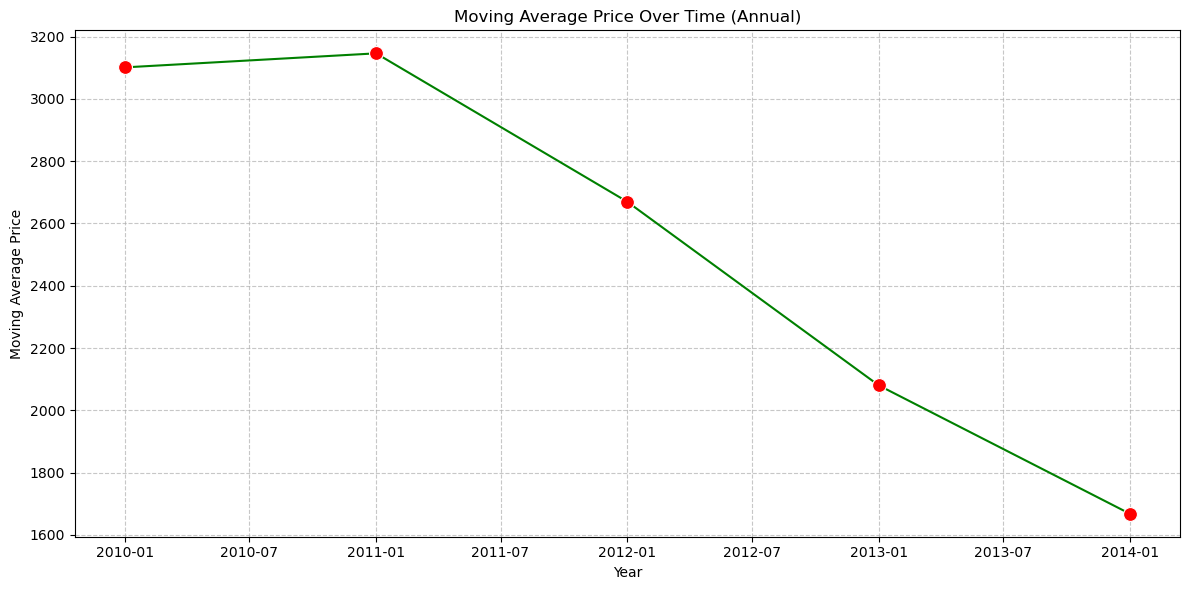

In [8]:
# Moving Average Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_cumm_analysis, x='order_date', y='moving_average_price', marker='o', color='green')
sns.scatterplot(data=df_cumm_analysis, x='order_date', y='moving_average_price', color='red', s=100, zorder=5)
plt.title('Moving Average Price Over Time (Annual)')
plt.xlabel('Year')
plt.ylabel('Moving Average Price')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

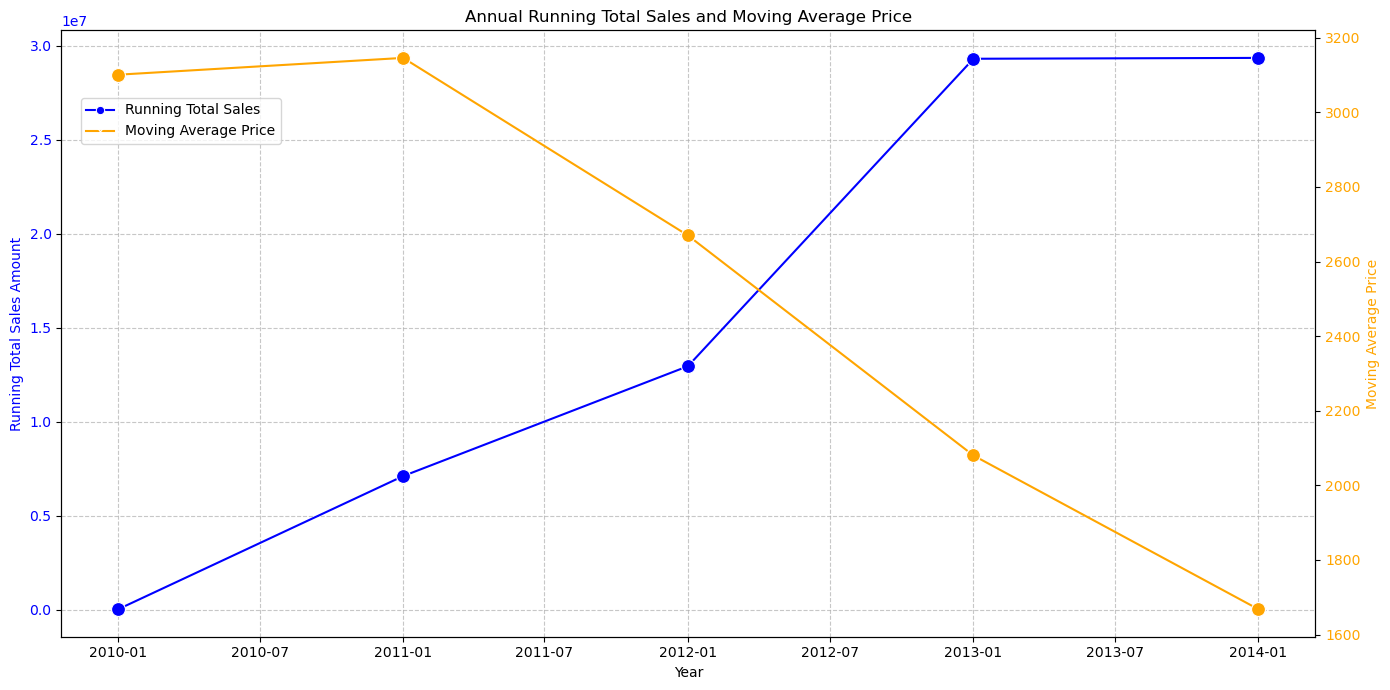

In [16]:
# Combined Vizualization
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Running Total Sales on primary y-axis (ax1)
sns.lineplot(data=df_cumm_analysis, x='order_date', y='running_total_sales', marker='o', ax=ax1,label='Running Total Sales', color='blue',legend=False)
sns.scatterplot(data=df_cumm_analysis, x='order_date', y='running_total_sales', color='blue', s=100, zorder=5, ax=ax1,legend=False)
ax1.set_xlabel('Year')
ax1.set_ylabel('Running Total Sales Amount', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a secondary y-axis (ax2) for Moving Average Price
ax2 = ax1.twinx()
sns.lineplot(data=df_cumm_analysis, x='order_date', y='moving_average_price', marker='x', ax=ax2,label='Moving Average Price', color='orange',legend=False)
sns.scatterplot(data=df_cumm_analysis, x='order_date', y='moving_average_price', color='orange', s=100, zorder=5, ax=ax2,legend=False)
ax2.set_ylabel('Moving Average Price', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Annual Running Total Sales and Moving Average Price')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left", bbox_to_anchor=(0.01,0.9),frameon=True)
plt.tight_layout()
plt.show()